### Libraries and definitions

In [43]:
%matplotlib inline
from prody import *
from pylab import *
from matplotlib import pyplot as plt

In [1]:
!source activate eman-env


INFO: eman-deps activation script is making the following environmental changes:
++++ LDFLAGS=
++++ LDFLAGS=
++++ CXXFLAGS=
++++ set +x



In [78]:
jobdir='automated_bodies'
input_map='/Users/fpoitevi/gdrive/cryoEM/Projects/2016-rib70s-F20/processing/PostProcess/job041/postprocess_masked.mrc'
threshold=0.02
reduction_level=3
n_modes=1
prefix=jobdir+'/test'

### map to pdb

In [79]:
!em2dam $input_map -t $threshold -p $prefix -r $reduction_level

In [93]:
!ls $jobdir/*

automated_bodies/test.dat automated_bodies/test.nmd automated_bodies/test.pdb


### pdb to covariance matrix

In [81]:
pdb_data = parsePDB(prefix+'.pdb')
calphas = pdb_data.select('protein and name CA')

@> 6559 atoms and 1 coordinate set(s) were parsed in 0.04s.


In [82]:
anm = ANM('bodies test ANM analysis')
anm.buildHessian(calphas,cutoff=30)
anm.calcModes(n_modes=n_modes)
writeNMD(prefix+'.nmd', anm[:10], calphas)

@> Hessian was built in 11.14s.
@> 1 modes were calculated in 764.37s.


'automated_bodies/test.nmd'

In [76]:
covar = anm.getCovariance()

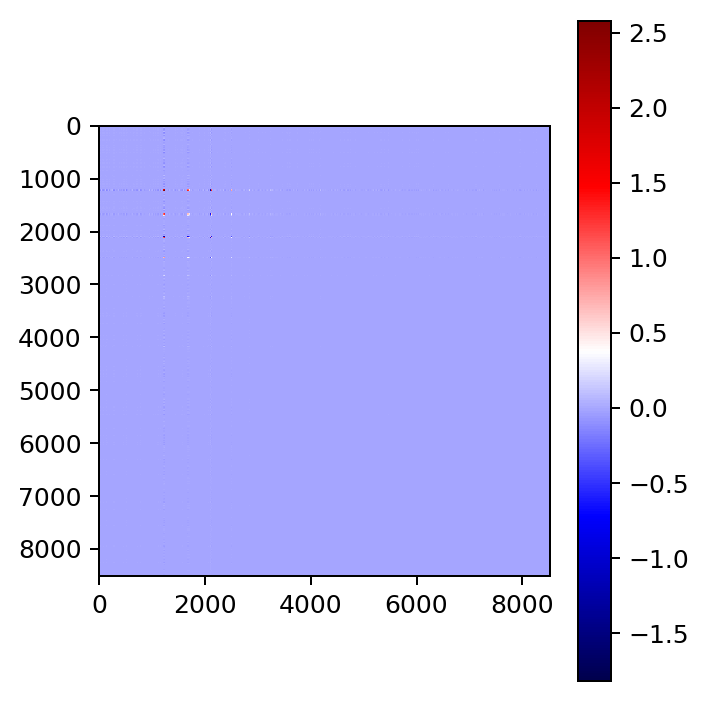

In [77]:
fig = plt.figure(figsize=(4,4),dpi=180)
plt.imshow(covar,cmap='seismic')
plt.colorbar()
plt.tight_layout()

In [92]:
coords = calphas.getCoords()
coords.shape

(6559, 3)

### covariance (+coords) to domain decomposition

We build the similarity matrix $\sigma$ as follows.

From the structure $\mathbf{X}_{i=1,N}$, we computed the covariance matrix $\mathbf{C}_{i\alpha,j\beta}=<X_{i\alpha}X_{j\beta}>$. 

We are now interested in computing the similarity matrix $\sigma_{ij}^{2}\ =\ <(d_{ij}-<d_{ij}>)^{2}>\ =\ <d_{ij}^{2}> - <d_{ij}>^{2}$

$<d_{ij}^{2}> = \sum_{\alpha}C_{i\alpha,i\alpha} + \sum_{\alpha}C_{j\alpha,j\alpha} - 2\sum_{\alpha}C_{i\alpha,j\alpha}$

$<d_{ij}>^{2} = \sum_{\alpha}(X_{j\alpha}-X_{i\alpha})^{2}$

In [ ]:
def pdb2simil(pdb_filename,n_modes=1,writenmd=False):
    """pdb2simil: from structure to similarity matrix
    """
    # load PDB file
    pdb_data = parsePDB(pdb_filename)
    calphas = pdb_data.select('protein and name CA')
    # get coordinates
    coords = calphas.getCoords()
    # get covariance matrix
    anm = ANM('bodies test ANM analysis')
    anm.buildHessian(calphas,cutoff=30)
    anm.calcModes(n_modes=n_modes)
    if(writenmd):
        writeNMD(prefix+'.nmd', anm[:10], calphas)
    covar = anm.getCovariance()
    #

### domain decomposition to body definition